In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import pickle as pkl
from collections import defaultdict
from matplotlib import rc
import pandas as pd
from itertools import cycle

## Obtaining reward rates

In [2]:
# upload multi-content CTR data processed by Yahoo CTR Jupyter Notebook
CTR_data = pkl.load(open("CTR_data_24h.pkl",'rb'))

In [3]:
# reward rates of K=20 arms and T=86404 rounds (array size: 20*86404)
CTR_data

array([[0.02471751, 0.02471751, 0.02471751, ..., 0.01125   , 0.01125   ,
        0.01125   ],
       [0.05448029, 0.05448029, 0.05448029, ..., 0.03331909, 0.03331909,
        0.03331909],
       [0.05420431, 0.05420431, 0.05420431, ..., 0.02542726, 0.02543786,
        0.02543786],
       ...,
       [0.04043127, 0.04043127, 0.04040406, ..., 0.03677278, 0.03677278,
        0.03677278],
       [0.03251534, 0.03251534, 0.03251534, ..., 0.02639656, 0.02639656,
        0.02639656],
       [0.01697128, 0.01697128, 0.01697128, ..., 0.01517615, 0.01517615,
        0.01517615]])

## Generating reward tapes from reward rates

In [4]:
def Sampling(mean_values, num_trials, num_samples):
    ''' 
    Generate the Binomial rewards of the changing arm given mean reward rates
    Can be modified to generate Bernoulli rewards and N reward tapes
    input: 
        - mean_values: reward rates of K arms and T rounds (np.array)
        - num_trials: number of trials (1 for bernoulli)
        - num_samples: number of reward tapes N
    output: 
        N reward tapes (3d np.array, 1st dim is N, 2nd and 3rd dim are the same as mean_values)
    '''
    # Generate random Bernoulli rewards based on the rates
    bernoulli_output = np.random.binomial(n=num_trials, p=mean_values, size=(num_samples,)+mean_values.shape)

    return bernoulli_output

In [5]:
bernoulli_rewards = Sampling(mean_values=CTR_data, num_trials=1, num_samples=100)
bernoulli_rewards

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Functions for computing regrets based on OPT and ALG rewards

### Rexp3 regret

In [6]:
def Rexp3Protocol(num_arms, gamma, batch_size, rates, tape):
    '''     
    Interaction between the Rexp3 algorithm and the enviornment
    input: 
        - num_arms: number of arms K (int)
        - gamma: exploration probability γ (float between 0 and 1)
        - batch_size: the length of each epoch (batch) Δ_T (int)
        - rates: mean reward rates (np.array)
        - tape: reward tape (np.array)
    output: optimal reward, algorithm reward, regret
    '''

    opt_reward = OPT(rates)
  
    alg_reward = Rexp3(num_arms=num_arms, batch_size=batch_size, gamma=gamma, tape=tape)
    
    regret = opt_reward - alg_reward
    
    return opt_reward, alg_reward, regret

### BE regret

In [7]:
def Protocol(budget, size, rates, tape):
    '''     
    Interaction between the BE algorithm and the enviornment
    input:
        - budget: budget for each epoch B_T (float)
        - size: the length of each epoch Δ_T (int)
        - rates: mean reward rates (np.array)
        - tape: reward tape (np.array)
    output: optimal reward, algorithm reward, regret
    '''

    opt_reward = OPT(rates)
  
    alg_reward = BudgetedExploration(budget, size, tape)
    
    regret = opt_reward - alg_reward
    
    return alg_reward, regret

### OPT regret

In [8]:
def OPT(rates):
    '''
    Get the optimal reward of an instance of rates
    input: 
        - rates: mean reward rates (np.array)
    '''

    opt = np.sum(np.max(rates,axis=0))  # recall that the optimal policy receives reward max(E[tape1[t]], E[tape2[t]]) at time t
    
    return opt

## Functions for computing ALG rewards

### BE algorithm (simple version)

In [10]:
def BE(budget, epoch_size, tape):
    ''' 
    Budgeted Exploration Algorithm 
    input:
        - budget: budget for each epoch B (float)
        - size: the length of each epoch Δ (int)
        - tape: reward tape (np.array)
    output: algorithm reward (int if Bernoulli rewards, float if Binomial rewards)
    
    Original BE Algorithm: 
    - Partition the horizon into epochs of length Δ.  
    - In each epoch, 
        1. reset cum reward = 0 for all arms
        2. round robin over the alive arms
        3. eliminate an arm if its cum reward is lower than that of some other arm by >= B  
    '''
        
    num_arms, time_horizon = tape.shape  # K and T
    alg_reward = 0  # total reward collected by BE
    t = 0  # initial time
    epoch_number = time_horizon//epoch_size  # number of epoches (excluding the last imcomplete one)
    
    for i in range(epoch_number+1):
        cum_rewards = np.zeros(num_arms)  # RESET cumulative rewards of each arm
        alive_arms = [a for a in range(num_arms)]  # RESET alive arms
        num_alive_arms = len(alive_arms)
        while len(alive_arms) >= 2 and t+num_alive_arms <= min((i+1)*epoch_size, time_horizon):
            for a in alive_arms: 
                cum_rewards[a] = cum_rewards[a] + tape[a,t]  # update cumulative rewards with the observed reward
                t = t + 1
            max_cum_reward = np.max(cum_rewards)  # largest cumulative reward
            alive_arms = [a for a in alive_arms if cum_rewards[a] >= max_cum_reward - budget]  # eliminate arms that run out of budget
            if (len(alive_arms) < num_alive_arms):
                num_alive_arms = len(alive_arms)
        
        while t < min((i+1)*epoch_size, time_horizon):  # exploit the only alive arm until the epoch ends
            for a in alive_arms:
                if t >= min((i + 1) * epoch_size, time_horizon):
                    break  # Stop pulling arms if the epoch ends
                cum_rewards[a] = cum_rewards[a] + tape[a,t]
                t = t + 1
        
        epoch_reward = np.sum(cum_rewards)
        alg_reward = alg_reward + epoch_reward
        
    return alg_reward

### BE algorithm (efficient version)

In [9]:
def BudgetedExploration(budget, size, tape):
    ''' 
    Budgeted Exploration Algorithm 
    input:
        - budget: budget for each epoch B (float)
        - size: the length of each epoch Δ (int)
        - tape: reward tape (np.array)
    output: algorithm reward (int if Bernoulli rewards, float if Binomial rewards)
    
    Original BE Algorithm: 
    - Partition the horizon into epochs of length Δ.  
    - In each epoch, 
        1. reset cum reward = 0 for all arms
        2. round robin over the alive arms
        3. eliminate an arm if its cum reward is lower than that of some other arm by >= B
    
    For computational efficiency, we consider the following twist: 
        In step 2 and 3, instead of doing round robin, with the knowledge of the entire "reward tape", we 
    compute the elimination time of the arms.  
    '''
    num_arms, time_horizon = tape.shape  # K and T
    alg_reward = 0  # total reward collected by BE
    t = 0  # initial time
    epoch_index = 0
    
    while t < time_horizon:
        k = num_arms  # RESET the number of alive arms in this epoch
        active = np.arange(k)  # indices of active arms in this epoch
        epoch_reward = 0 # RESET total rewards collected by BE in this epoch
        cum_rewards = np.zeros(k)  # RESET cumulative rewards of each arm
        tau = 0  # RESET the exploration stopping time in this epoch
        epoch_size = min(size, time_horizon-t)  # due to INTEGRALITY ISSUES, the last epoch may have a smaller size
        epoch_start = t+epoch_size  # start of the next epoch (end of this epoch)
        
        while (epoch_size-tau >= k) and (k > 1):  # while not reach the end of the epoch and more than one arm active
            j = (epoch_size-tau)//k  # number of times each active arm can be pulled in the remaining rounds of this epoch
            explore_rewards = np.zeros([k,j])  # rewards of active arms to be explored
            
            for i in range(k):  # alive arms are pulled in a round-robin manner
                explore_rewards[i] = tape[active[i],t+i:t+k*j:k]
                
            cumsum_rewards = cum_rewards.reshape(k,1)+np.cumsum(explore_rewards, axis=1)  # cumulative sum of rewards of active arms
            diff = np.max(cumsum_rewards,axis=0) - np.min(cumsum_rewards,axis=0)  # max difference in cumulative sum
            
            if np.where(diff>budget)[0].size == 0:  # if the max difference does not exceed the budget
                epoch_reward = epoch_reward-np.sum(cum_rewards)+np.sum(cumsum_rewards[:,-1])  # update total reward collected in this epoch
                cum_rewards = cumsum_rewards[:,-1]  # no arm is eliminated, update the cumulative rewards of active arms
                t = t + k*j  # each active arm is pulled j more times since last arm elimination
                tau = tau + k*j  # update exploration stopping time
                
                
            else:  # if the max difference starts to exceed the budget
                s = np.where(diff>budget)[0][0]  # stop exploration after each active arm is pulled s times since last arm elimination
                max_cumsum_reward = np.max(cumsum_rewards[:,s],axis=0)
                eliminated = np.where(cumsum_rewards[:,s] < max_cumsum_reward - budget)  # eliminate arms that run out of budget
                epoch_reward = epoch_reward-np.sum(cum_rewards)+np.sum(cumsum_rewards[:,s])  # update total reward collected in this epoch
                cum_rewards = cumsum_rewards[:,s]  # update the cumulative rewards of active arms
                cum_rewards = np.delete(cum_rewards, eliminated)
                active = np.delete(active, eliminated)  # update the alive arms
                
                t = t + k*(s+1)  # each alive arm is pulled j more times since last arm elimination
                tau = tau + k*(s+1)  # update exploration stopping time
                k = len(active)  # update number of active arms

        epoch_reward = epoch_reward+np.sum(tape[active[0], t:epoch_start])  # exploit the optimal arm till the end of this epoch
        
        epoch_index = epoch_index + 1
        alg_reward = alg_reward + epoch_reward  # add rewards collected in this epoch to the total rewards
        t = epoch_start # start a new epoch
    
    return alg_reward

### Rexp3 algorithm

In [11]:
def Rexp3(num_arms, gamma, batch_size, tape):
    ''' 
    Rexp3 Algorithm 
    input:
        - num_arms: number of arms K (int)
        - gamma: exploration probability γ (float between 0 and 1)
        - batch_size: the length of each epoch (batch) Δ_T (int)
        - tape: reward tape (np.array)
    output: algorithm reward
    '''
    alg_reward = 0
    batch_index = 0
    horizon = tape.shape[1]
    rand_values = np.random.rand(horizon)
    
    while batch_index <= (horizon//batch_size):
        tau = batch_index * batch_size
        weights = np.ones(num_arms)
        for t in range(tau, min(tau+batch_size, horizon)):
            # Probability distribution for drawing arms
            dist = (1 - gamma) * weights / np.sum(weights) + gamma / num_arms
            
            # Draw an arm randomly with probability proportional to the weight of the arm
#             chosen_arm = np.random.choice(num_arms, p=distribution)
            cum_dist = np.cumsum(dist)
            chosen_arm = np.searchsorted(cum_dist,rand_values[t])
            
            # Receive a reward
            reward = rates[chosen_arm][t]
            alg_reward = alg_reward + reward
            
            # Update the weight for the chosen arm
            prob = dist[chosen_arm]
            weights[chosen_arm] = weights[chosen_arm] * np.exp(gamma * (reward / prob) / num_arms)
        batch_index = batch_index+1
    return alg_reward

## Computing BE regrets over different time horizons

In [30]:
T = CTR_data.shape[1]  # start with time horizon equal to the length of the dataset
K = CTR_data.shape[0]  # number of arms
logT = math.floor(np.log2(T))  # log of time horizon
L = 0.5  # Lipschitz constant, selected based on np.sum(np.max(CTR_data,axis=1)-np.min(CTR_data,axis=1))
num_instances = 100 

regrets1 = np.zeros((num_instances,logT+1))
regrets2 = np.zeros((num_instances,logT+1))
opt_rewards = np.zeros((num_instances,logT+1))
alg_rewards1 = np.zeros((num_instances,logT+1))
alg_rewards2 = np.zeros((num_instances,logT+1))

for j in range(num_instances):
    reward_rates = np.copy(CTR_data)
    reward_tape = np.copy(bernoulli_rewards[j])
    T = CTR_data.shape[1]  # start with time horizon equal to the length of the dataset
    print("instance:", j)
    while T>300: 
        start = time.time()
        i = math.floor(np.log2(T))
        print("log horizon:", i)

        B1 = 0.1*L**(-1/3)*K**(-1/2)*np.log(K)**(1/2)*T**(1/3)*np.log(T)**(1/3)  # budget of ALG1
        DeltaT1 = int(L**(-2/3)*K**(-1/3)*np.log(K)**(1/3)*T**(2/3)*np.log(T)**(1/3))  # epoch size of ALG1
        B2 = 0.02*L**(-1/5)*K**(-1/2)*np.log(K)**(1/2)*T**(2/5)*np.log(T)**(3/5)  # budget of ALG2
        DeltaT2 = int(L**(-2/5)*K**(-3/5)*np.log(K)**(1/5)*T**(4/5)*np.log(T)**(1/5))  # epoch size of ALG2

        opt_rewards[j,i] = OPT(rates=reward_rates)  # OPT reward

        alg_rewards1[j,i], regrets1[j,i] = Protocol(budget=B1, size=DeltaT1, rates = reward_rates, tape=reward_tape)  # BE-NS reward
        alg_rewards2[j,i], regrets2[j,i] = Protocol(budget=B2, size=DeltaT2, rates = reward_rates, tape=reward_tape)  # BE-S reward

        T = int(T/2)  # consider time horizon T/2 next
        reward_rates = reward_rates[:,::2]  # rates of time horizon T/2, by selecting the even elements from rates of time horizon T
        reward_tape = reward_tape[:,::2]
        end = time.time()
        print("time:", end-start)
        print('regret:', regrets1[j,i], regrets2[j,i])
        print()
    print()
    print()

instance: 0
log horizon: 16
time: 0.039897918701171875
regret: 1174.1760046585396 885.1760046585396

log horizon: 15
time: 0.01782703399658203
regret: 619.5930594745246 515.5930594745246

log horizon: 14
time: 0.009897947311401367
regret: 381.3021671730471 244.3021671730471

log horizon: 13
time: 0.006443977355957031
regret: 162.17619936448682 157.17619936448682

log horizon: 12
time: 0.004644870758056641
regret: 71.10020762195927 67.10020762195927

log horizon: 11
time: 0.002190113067626953
regret: 54.07654780321127 30.07654780321127

log horizon: 10
time: 0.0018680095672607422
regret: 30.05877649857699 34.05877649857699

log horizon: 9
time: 0.0012989044189453125
regret: 11.066894051783535 10.066894051783535

log horizon: 8
time: 0.001077890396118164
regret: 10.539738632212373 3.539738632212373



instance: 1
log horizon: 16
time: 0.03090500831604004
regret: 1316.1760046585396 830.1760046585396

log horizon: 15
time: 0.01647210121154785
regret: 668.5930594745246 594.5930594745246

lo

time: 0.009449005126953125
regret: 322.3021671730471 264.3021671730471

log horizon: 13
time: 0.00680088996887207
regret: 202.17619936448682 120.17619936448682

log horizon: 12
time: 0.004845619201660156
regret: 74.10020762195927 74.10020762195927

log horizon: 11
time: 0.0023908615112304688
regret: 37.07654780321127 43.07654780321127

log horizon: 10
time: 0.0013229846954345703
regret: 25.05877649857699 35.05877649857699

log horizon: 9
time: 0.0011022090911865234
regret: 17.066894051783535 19.066894051783535

log horizon: 8
time: 0.0009248256683349609
regret: 5.539738632212373 1.539738632212373



instance: 11
log horizon: 16
time: 0.029567956924438477
regret: 1200.1760046585396 987.1760046585396

log horizon: 15
time: 0.018001079559326172
regret: 580.5930594745246 479.5930594745246

log horizon: 14
time: 0.009641885757446289
regret: 235.3021671730471 252.3021671730471

log horizon: 13
time: 0.006742000579833984
regret: 163.17619936448682 176.17619936448682

log horizon: 12
time: 0.0

time: 0.03020501136779785
regret: 1144.1760046585396 956.1760046585396

log horizon: 15
time: 0.01760578155517578
regret: 600.5930594745246 525.5930594745246

log horizon: 14
time: 0.009743928909301758
regret: 362.3021671730471 267.3021671730471

log horizon: 13
time: 0.00595402717590332
regret: 193.17619936448682 179.17619936448682

log horizon: 12
time: 0.0048677921295166016
regret: 111.10020762195927 102.10020762195927

log horizon: 11
time: 0.0025641918182373047
regret: 48.07654780321127 28.07654780321127

log horizon: 10
time: 0.0017008781433105469
regret: 29.05877649857699 14.05877649857699

log horizon: 9
time: 0.0014488697052001953
regret: 1.0668940517835352 12.066894051783535

log horizon: 8
time: 0.0008907318115234375
regret: -1.460261367787627 9.539738632212373



instance: 22
log horizon: 16
time: 0.02989792823791504
regret: 1133.1760046585396 1145.1760046585396

log horizon: 15
time: 0.01605510711669922
regret: 558.5930594745246 501.5930594745246

log horizon: 14
time: 0.0

time: 0.004979848861694336
regret: 64.10020762195927 115.10020762195927

log horizon: 11
time: 0.002470731735229492
regret: 41.07654780321127 57.07654780321127

log horizon: 10
time: 0.0013272762298583984
regret: 40.05877649857699 20.05877649857699

log horizon: 9
time: 0.0013070106506347656
regret: 13.066894051783535 9.066894051783535

log horizon: 8
time: 0.0008437633514404297
regret: 5.539738632212373 10.539738632212373



instance: 32
log horizon: 16
time: 0.03144478797912598
regret: 1210.1760046585396 949.1760046585396

log horizon: 15
time: 0.016740083694458008
regret: 656.5930594745246 615.5930594745246

log horizon: 14
time: 0.009637832641601562
regret: 359.3021671730471 328.3021671730471

log horizon: 13
time: 0.006448030471801758
regret: 186.17619936448682 165.17619936448682

log horizon: 12
time: 0.004417896270751953
regret: 124.10020762195927 88.10020762195927

log horizon: 11
time: 0.0019690990447998047
regret: 59.07654780321127 51.07654780321127

log horizon: 10
time: 0.0

time: 0.03152060508728027
regret: 1251.1760046585396 940.1760046585396

log horizon: 15
time: 0.017388105392456055
regret: 638.5930594745246 501.5930594745246

log horizon: 14
time: 0.009130001068115234
regret: 247.3021671730471 271.3021671730471

log horizon: 13
time: 0.0062100887298583984
regret: 180.17619936448682 186.17619936448682

log horizon: 12
time: 0.004174232482910156
regret: 97.10020762195927 101.10020762195927

log horizon: 11
time: 0.0024938583374023438
regret: 44.07654780321127 41.07654780321127

log horizon: 10
time: 0.0016193389892578125
regret: 21.05877649857699 33.05877649857699

log horizon: 9
time: 0.0014078617095947266
regret: 11.066894051783535 8.066894051783535

log horizon: 8
time: 0.001180887222290039
regret: 3.539738632212373 8.539738632212373



instance: 45
log horizon: 16
time: 0.029838085174560547
regret: 963.1760046585396 974.1760046585396

log horizon: 15
time: 0.016778945922851562
regret: 599.5930594745246 659.5930594745246

log horizon: 14
time: 0.009

instance: 55
log horizon: 16
time: 0.030293941497802734
regret: 1205.1760046585396 994.1760046585396

log horizon: 15
time: 0.01744699478149414
regret: 648.5930594745246 527.5930594745246

log horizon: 14
time: 0.009746313095092773
regret: 374.3021671730471 393.3021671730471

log horizon: 13
time: 0.006446123123168945
regret: 147.17619936448682 170.17619936448682

log horizon: 12
time: 0.004739999771118164
regret: 94.10020762195927 124.10020762195927

log horizon: 11
time: 0.002249002456665039
regret: 58.07654780321127 28.07654780321127

log horizon: 10
time: 0.0016911029815673828
regret: 30.05877649857699 26.05877649857699

log horizon: 9
time: 0.0014472007751464844
regret: 20.066894051783535 12.066894051783535

log horizon: 8
time: 0.0009601116180419922
regret: 6.539738632212373 7.539738632212373



instance: 56
log horizon: 16
time: 0.030488967895507812
regret: 1293.1760046585396 1021.1760046585396

log horizon: 15
time: 0.01848292350769043
regret: 683.5930594745246 628.593059474524

time: 0.016566991806030273
regret: 643.5930594745246 535.5930594745246

log horizon: 14
time: 0.008913278579711914
regret: 374.3021671730471 340.3021671730471

log horizon: 13
time: 0.006100177764892578
regret: 179.17619936448682 159.17619936448682

log horizon: 12
time: 0.0043489933013916016
regret: 83.10020762195927 88.10020762195927

log horizon: 11
time: 0.002466917037963867
regret: 44.07654780321127 31.07654780321127

log horizon: 10
time: 0.0015070438385009766
regret: 12.05877649857699 25.05877649857699

log horizon: 9
time: 0.0012950897216796875
regret: 2.0668940517835352 13.066894051783535

log horizon: 8
time: 0.0010790824890136719
regret: 5.539738632212373 5.539738632212373



instance: 66
log horizon: 16
time: 0.03134274482727051
regret: 1136.1760046585396 932.1760046585396

log horizon: 15
time: 0.01713109016418457
regret: 695.5930594745246 595.5930594745246

log horizon: 14
time: 0.008650064468383789
regret: 317.3021671730471 266.3021671730471

log horizon: 13
time: 0.0061

time: 0.031373023986816406
regret: 1029.1760046585396 936.1760046585396

log horizon: 15
time: 0.018343210220336914
regret: 613.5930594745246 508.5930594745246

log horizon: 14
time: 0.009240150451660156
regret: 287.3021671730471 273.3021671730471

log horizon: 13
time: 0.0067598819732666016
regret: 168.17619936448682 156.17619936448682

log horizon: 12
time: 0.004830121994018555
regret: 101.10020762195927 81.10020762195927

log horizon: 11
time: 0.002162933349609375
regret: 65.07654780321127 49.07654780321127

log horizon: 10
time: 0.001664876937866211
regret: 34.05877649857699 27.05877649857699

log horizon: 9
time: 0.0014190673828125
regret: 13.066894051783535 8.066894051783535

log horizon: 8
time: 0.0010929107666015625
regret: 1.539738632212373 2.539738632212373



instance: 77
log horizon: 16
time: 0.03263115882873535
regret: 1151.1760046585396 1036.1760046585396

log horizon: 15
time: 0.016545772552490234
regret: 640.5930594745246 483.5930594745246

log horizon: 14
time: 0.00964

instance: 87
log horizon: 16
time: 0.03101491928100586
regret: 1138.1760046585396 914.1760046585396

log horizon: 15
time: 0.017394065856933594
regret: 608.5930594745246 509.5930594745246

log horizon: 14
time: 0.009504079818725586
regret: 296.3021671730471 258.3021671730471

log horizon: 13
time: 0.005991935729980469
regret: 212.17619936448682 180.17619936448682

log horizon: 12
time: 0.004303932189941406
regret: 104.10020762195927 117.10020762195927

log horizon: 11
time: 0.0024156570434570312
regret: 53.07654780321127 41.07654780321127

log horizon: 10
time: 0.0015358924865722656
regret: 34.05877649857699 36.05877649857699

log horizon: 9
time: 0.001341104507446289
regret: 2.0668940517835352 19.066894051783535

log horizon: 8
time: 0.0010869503021240234
regret: 6.539738632212373 9.539738632212373



instance: 88
log horizon: 16
time: 0.03066706657409668
regret: 1280.1760046585396 883.1760046585396

log horizon: 15
time: 0.017981290817260742
regret: 630.5930594745246 619.593059474524

time: 0.01806187629699707
regret: 622.5930594745246 562.5930594745246

log horizon: 14
time: 0.009170293807983398
regret: 323.3021671730471 228.3021671730471

log horizon: 13
time: 0.006688833236694336
regret: 176.17619936448682 210.17619936448682

log horizon: 12
time: 0.004896879196166992
regret: 95.10020762195927 118.10020762195927

log horizon: 11
time: 0.0025382041931152344
regret: 58.07654780321127 55.07654780321127

log horizon: 10
time: 0.0013959407806396484
regret: 43.05877649857699 27.05877649857699

log horizon: 9
time: 0.0012021064758300781
regret: 16.066894051783535 17.066894051783535

log horizon: 8
time: 0.0009930133819580078
regret: 4.539738632212373 4.539738632212373



instance: 98
log horizon: 16
time: 0.030424833297729492
regret: 1268.1760046585396 855.1760046585396

log horizon: 15
time: 0.017826080322265625
regret: 686.5930594745246 508.5930594745246

log horizon: 14
time: 0.010007143020629883
regret: 257.3021671730471 298.3021671730471

log horizon: 13
time: 0.00

In [31]:
regrets1

array([[   0.        ,    0.        ,    0.        , ...,  381.30216717,
         619.59305947, 1174.17600466],
       [   0.        ,    0.        ,    0.        , ...,  359.30216717,
         668.59305947, 1316.17600466],
       [   0.        ,    0.        ,    0.        , ...,  302.30216717,
         539.59305947, 1099.17600466],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  323.30216717,
         622.59305947, 1016.17600466],
       [   0.        ,    0.        ,    0.        , ...,  257.30216717,
         686.59305947, 1268.17600466],
       [   0.        ,    0.        ,    0.        , ...,  312.30216717,
         634.59305947, 1043.17600466]])

In [32]:
regrets2

array([[  0.        ,   0.        ,   0.        , ..., 244.30216717,
        515.59305947, 885.17600466],
       [  0.        ,   0.        ,   0.        , ..., 299.30216717,
        594.59305947, 830.17600466],
       [  0.        ,   0.        ,   0.        , ..., 263.30216717,
        608.59305947, 992.17600466],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 228.30216717,
        562.59305947, 930.17600466],
       [  0.        ,   0.        ,   0.        , ..., 298.30216717,
        508.59305947, 855.17600466],
       [  0.        ,   0.        ,   0.        , ..., 280.30216717,
        546.59305947, 923.17600466]])

In [33]:
alg_rewards1

array([[   0.,    0.,    0., ...,  675., 1493., 3051.],
       [   0.,    0.,    0., ...,  697., 1444., 2909.],
       [   0.,    0.,    0., ...,  754., 1573., 3126.],
       ...,
       [   0.,    0.,    0., ...,  733., 1490., 3209.],
       [   0.,    0.,    0., ...,  799., 1426., 2957.],
       [   0.,    0.,    0., ...,  744., 1478., 3182.]])

In [34]:
alg_rewards2

array([[   0.,    0.,    0., ...,  812., 1597., 3340.],
       [   0.,    0.,    0., ...,  757., 1518., 3395.],
       [   0.,    0.,    0., ...,  793., 1504., 3233.],
       ...,
       [   0.,    0.,    0., ...,  828., 1550., 3295.],
       [   0.,    0.,    0., ...,  758., 1604., 3370.],
       [   0.,    0.,    0., ...,  776., 1566., 3302.]])

In [35]:
opt_rewards

array([[   0.        ,    0.        ,    0.        , ..., 1056.30216717,
        2112.59305947, 4225.17600466],
       [   0.        ,    0.        ,    0.        , ..., 1056.30216717,
        2112.59305947, 4225.17600466],
       [   0.        ,    0.        ,    0.        , ..., 1056.30216717,
        2112.59305947, 4225.17600466],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1056.30216717,
        2112.59305947, 4225.17600466],
       [   0.        ,    0.        ,    0.        , ..., 1056.30216717,
        2112.59305947, 4225.17600466],
       [   0.        ,    0.        ,    0.        , ..., 1056.30216717,
        2112.59305947, 4225.17600466]])

In [27]:
np.mean(alg_rewards1,axis=0)

array([   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,   10.83,   22.79,   41.91,   89.05,  188.  ,  376.08,
        794.27, 1619.69, 3361.38])

In [28]:
np.mean(alg_rewards2,axis=0)

array([   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,   10.16,   21.8 ,   42.72,   87.6 ,  181.  ,  386.83,
        790.84, 1630.52, 3412.09])

## Compute Rexp3  regrets over different time horizons

In [49]:
T = CTR_data.shape[1]  # start with time horizon equal to the length of the dataset
V = 0.5  # total variation budget
K = 20  # number of arms
l = math.floor(np.log2(T))  # log of time horizon

regrets = np.zeros((num_instances,l+1))
opt_rewards = np.zeros((num_instances,l+1))
alg_rewards = np.zeros((num_instances,l+1))

for j in range(num_instances):
    rates = np.copy(CTR_data)
    tape = np.copy(bernoulli_rewards[j])
    T = CTR_data.shape[1]  # start with time horizon equal to the length of the dataset
    print("instance:", j)
    while T>300:

        i = math.floor(np.log2(T))  # log of time horizon
        print("log2 horizon:", math.floor(np.log2(T)))
        Delta = math.ceil((K*math.log(K))**(1/3)*(T/V)**(2/3))  # batch size
        gamma = min(1, math.sqrt(K*math.log(K)/((math.e-1)*Delta)))  # exploration probability
        start = time.time()
        opt_rewards[j,i], alg_rewards[j,i], regrets[j,i] = Rexp3Protocol(num_arms=K, gamma=gamma, batch_size=Delta, rates=rates, tape=tape)
        end = time.time()
        print("time:", end-start)
        print('regret:', regrets[j,i])

        T = int(T/2)  # consider time horizon T/2 next
        rates = rates[:,::2]  # rates of time horizon T/2, by selecting the even elements from rates of time horizon T
        tape = tape[:,::2]

        i = i+1

instance: 0
log2 horizon: 16
time: 1.31361985206604
regret: 1630.0557484592068
log2 horizon: 15
time: 0.653738260269165
regret: 841.4999818858876
log2 horizon: 14
time: 0.31615710258483887
regret: 425.8505582099335
log2 horizon: 13
time: 0.14915871620178223
regret: 222.3776212449663
log2 horizon: 12
time: 0.06794595718383789
regret: 114.20108743473128
log2 horizon: 11
time: 0.03529191017150879
regret: 58.21529529589243
log2 horizon: 10
time: 0.01650214195251465
regret: 29.449658509056597
log2 horizon: 9
time: 0.008124828338623047
regret: 15.305883349377293
log2 horizon: 8
time: 0.004082918167114258
regret: 7.526328283878518
instance: 1
log2 horizon: 16
time: 1.2494196891784668
regret: 1624.4326817894398
log2 horizon: 15
time: 0.6298689842224121
regret: 841.794300401009
log2 horizon: 14
time: 0.2961270809173584
regret: 428.955702816217
log2 horizon: 13
time: 0.1515500545501709
regret: 220.09884291427693
log2 horizon: 12
time: 0.06739401817321777
regret: 113.86419555701926
log2 horizon: 

time: 1.2622230052947998
regret: 1620.0316403941665
log2 horizon: 15
time: 0.6308879852294922
regret: 836.4389079277316
log2 horizon: 14
time: 0.31009578704833984
regret: 429.37635479734445
log2 horizon: 13
time: 0.1514146327972412
regret: 225.36118710860205
log2 horizon: 12
time: 0.07526779174804688
regret: 113.10820083315679
log2 horizon: 11
time: 0.03495621681213379
regret: 56.930269916577174
log2 horizon: 10
time: 0.016450881958007812
regret: 28.91672084759513
log2 horizon: 9
time: 0.008185148239135742
regret: 15.039140731281744
log2 horizon: 8
time: 0.0040662288665771484
regret: 7.653199162750875
instance: 14
log2 horizon: 16
time: 1.2789242267608643
regret: 1628.6147770289376
log2 horizon: 15
time: 0.6657640933990479
regret: 834.7296185841581
log2 horizon: 14
time: 0.31067800521850586
regret: 431.2219910759951
log2 horizon: 13
time: 0.15098786354064941
regret: 223.80584350621973
log2 horizon: 12
time: 0.06911897659301758
regret: 113.58385254308979
log2 horizon: 11
time: 0.0326559

time: 1.241835117340088
regret: 1617.201686142842
log2 horizon: 15
time: 0.6234631538391113
regret: 833.5734531953585
log2 horizon: 14
time: 0.30101823806762695
regret: 427.7183641567707
log2 horizon: 13
time: 0.15604805946350098
regret: 223.72195263131312
log2 horizon: 12
time: 0.06937408447265625
regret: 114.45432555416386
log2 horizon: 11
time: 0.03275609016418457
regret: 58.803321537461315
log2 horizon: 10
time: 0.016282081604003906
regret: 29.042767867634645
log2 horizon: 9
time: 0.008147954940795898
regret: 15.332965456746305
log2 horizon: 8
time: 0.004069089889526367
regret: 6.988330361040509
instance: 27
log2 horizon: 16
time: 1.2902708053588867
regret: 1613.605210878597
log2 horizon: 15
time: 0.6346940994262695
regret: 839.342932162634
log2 horizon: 14
time: 0.3054080009460449
regret: 429.5166515747794
log2 horizon: 13
time: 0.1468970775604248
regret: 224.75356222803032
log2 horizon: 12
time: 0.06972122192382812
regret: 112.81970274387149
log2 horizon: 11
time: 0.0342521667480

time: 1.2664949893951416
regret: 1631.067517636171
log2 horizon: 15
time: 0.6171610355377197
regret: 831.3438488807103
log2 horizon: 14
time: 0.29027581214904785
regret: 426.76692300166826
log2 horizon: 13
time: 0.14556479454040527
regret: 223.56328360253542
log2 horizon: 12
time: 0.06822395324707031
regret: 115.62936364653842
log2 horizon: 11
time: 0.032631635665893555
regret: 58.556752486058556
log2 horizon: 10
time: 0.01623988151550293
regret: 29.54399912380459
log2 horizon: 9
time: 0.008139848709106445
regret: 14.559076888018815
log2 horizon: 8
time: 0.004081010818481445
regret: 7.322452027081214
instance: 40
log2 horizon: 16
time: 1.2450554370880127
regret: 1630.9498805606127
log2 horizon: 15
time: 0.6037099361419678
regret: 833.588742767013
log2 horizon: 14
time: 0.29091787338256836
regret: 430.8798444640306
log2 horizon: 13
time: 0.14058780670166016
regret: 218.4797203000959
log2 horizon: 12
time: 0.06678891181945801
regret: 113.44961518456185
log2 horizon: 11
time: 0.0359227657

time: 1.2700669765472412
regret: 1618.870490035727
log2 horizon: 15
time: 0.6081409454345703
regret: 840.9690447960925
log2 horizon: 14
time: 0.2876279354095459
regret: 424.1151503289127
log2 horizon: 13
time: 0.1387767791748047
regret: 225.08268346929242
log2 horizon: 12
time: 0.06954693794250488
regret: 113.87476496202356
log2 horizon: 11
time: 0.03392839431762695
regret: 57.23602980971492
log2 horizon: 10
time: 0.016366243362426758
regret: 29.195894328542607
log2 horizon: 9
time: 0.008107185363769531
regret: 14.894309327497503
log2 horizon: 8
time: 0.004086971282958984
regret: 7.22311833267279
instance: 53
log2 horizon: 16
time: 1.246263027191162
regret: 1627.198841571399
log2 horizon: 15
time: 0.609853982925415
regret: 841.158664513662
log2 horizon: 14
time: 0.29354333877563477
regret: 428.9789985080557
log2 horizon: 13
time: 0.14070987701416016
regret: 222.36971560594498
log2 horizon: 12
time: 0.06729817390441895
regret: 114.16504003263606
log2 horizon: 11
time: 0.0324487686157226

time: 1.2859551906585693
regret: 1637.8273545044176
log2 horizon: 15
time: 0.7532482147216797
regret: 839.7768491037216
log2 horizon: 14
time: 0.30928993225097656
regret: 425.5663874532223
log2 horizon: 13
time: 0.1462690830230713
regret: 220.53518855009554
log2 horizon: 12
time: 0.06962800025939941
regret: 114.51120864461006
log2 horizon: 11
time: 0.032938241958618164
regret: 57.746307121505126
log2 horizon: 10
time: 0.016518831253051758
regret: 29.692638847711407
log2 horizon: 9
time: 0.008291959762573242
regret: 14.858087753859078
log2 horizon: 8
time: 0.0041120052337646484
regret: 7.58659972583167
instance: 66
log2 horizon: 16
time: 1.2518088817596436
regret: 1622.0685851229541
log2 horizon: 15
time: 0.626101016998291
regret: 842.0531334514087
log2 horizon: 14
time: 0.29243922233581543
regret: 430.94143757760673
log2 horizon: 13
time: 0.15349984169006348
regret: 220.61753451972686
log2 horizon: 12
time: 0.06815218925476074
regret: 113.41424571510504
log2 horizon: 11
time: 0.0325119

time: 1.2364048957824707
regret: 1620.8189420620597
log2 horizon: 15
time: 0.6179141998291016
regret: 843.8059656023586
log2 horizon: 14
time: 0.293503999710083
regret: 428.7954405708215
log2 horizon: 13
time: 0.15706300735473633
regret: 222.6906580031192
log2 horizon: 12
time: 0.07010102272033691
regret: 113.00695030239535
log2 horizon: 11
time: 0.03328204154968262
regret: 57.31495157091307
log2 horizon: 10
time: 0.016356706619262695
regret: 29.275060246204923
log2 horizon: 9
time: 0.008133888244628906
regret: 14.544157859813293
log2 horizon: 8
time: 0.004071950912475586
regret: 7.445954141341579
instance: 79
log2 horizon: 16
time: 1.2722299098968506
regret: 1623.5384360785606
log2 horizon: 15
time: 0.6286702156066895
regret: 842.9786586767432
log2 horizon: 14
time: 0.2906346321105957
regret: 427.9505164531771
log2 horizon: 13
time: 0.15210294723510742
regret: 225.51888396796483
log2 horizon: 12
time: 0.0720210075378418
regret: 113.38522330502144
log2 horizon: 11
time: 0.0332338809967

time: 1.2371199131011963
regret: 1632.5592926350241
log2 horizon: 15
time: 0.6222331523895264
regret: 839.5917258979907
log2 horizon: 14
time: 0.28893065452575684
regret: 427.5515998676931
log2 horizon: 13
time: 0.14140605926513672
regret: 223.08805216084488
log2 horizon: 12
time: 0.06967878341674805
regret: 113.98103313806357
log2 horizon: 11
time: 0.033685922622680664
regret: 58.10511106073271
log2 horizon: 10
time: 0.017530202865600586
regret: 29.704860815732694
log2 horizon: 9
time: 0.008513212203979492
regret: 14.791910583597513
log2 horizon: 8
time: 0.0042459964752197266
regret: 7.459056301105635
instance: 92
log2 horizon: 16
time: 1.239088773727417
regret: 1633.8287361896241
log2 horizon: 15
time: 0.5844862461090088
regret: 836.7371877297362
log2 horizon: 14
time: 0.2829272747039795
regret: 429.7677336292685
log2 horizon: 13
time: 0.14442896842956543
regret: 224.43072315226732
log2 horizon: 12
time: 0.07543277740478516
regret: 114.20755328416402
log2 horizon: 11
time: 0.03664994

In [80]:
regrets

array([[   0.        ,    0.        ,    0.        , ...,  425.85055821,
         841.49998189, 1630.05574846],
       [   0.        ,    0.        ,    0.        , ...,  428.95570282,
         841.7943004 , 1624.43268179],
       [   0.        ,    0.        ,    0.        , ...,  426.63709699,
         832.87673176, 1627.48093151],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  427.85141099,
         834.70663321, 1632.45623825],
       [   0.        ,    0.        ,    0.        , ...,  427.44888507,
         832.74740505, 1633.04448758],
       [   0.        ,    0.        ,    0.        , ...,  427.68037122,
         843.50433794, 1615.20941157]])

In [81]:
np.mean(regrets,axis=0)

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          7.39436361,   14.77901474,   29.25200132,   57.88651867,
        114.17620907,  222.80739482,  427.69021837,  839.2521619 ,
       1627.05503059])

In [59]:
np.mean(alg_rewards,axis=0)

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          9.768745  ,   19.53144365,   39.32784582,   79.2189825 ,
        159.99257129,  325.47546178,  668.8188198 , 1353.74498968,
       2758.92950672])

## Plotting regret growth curves

Text(0.5, 1.0, 'Regret as a function of horizon length T (base-10 log-log plot)')

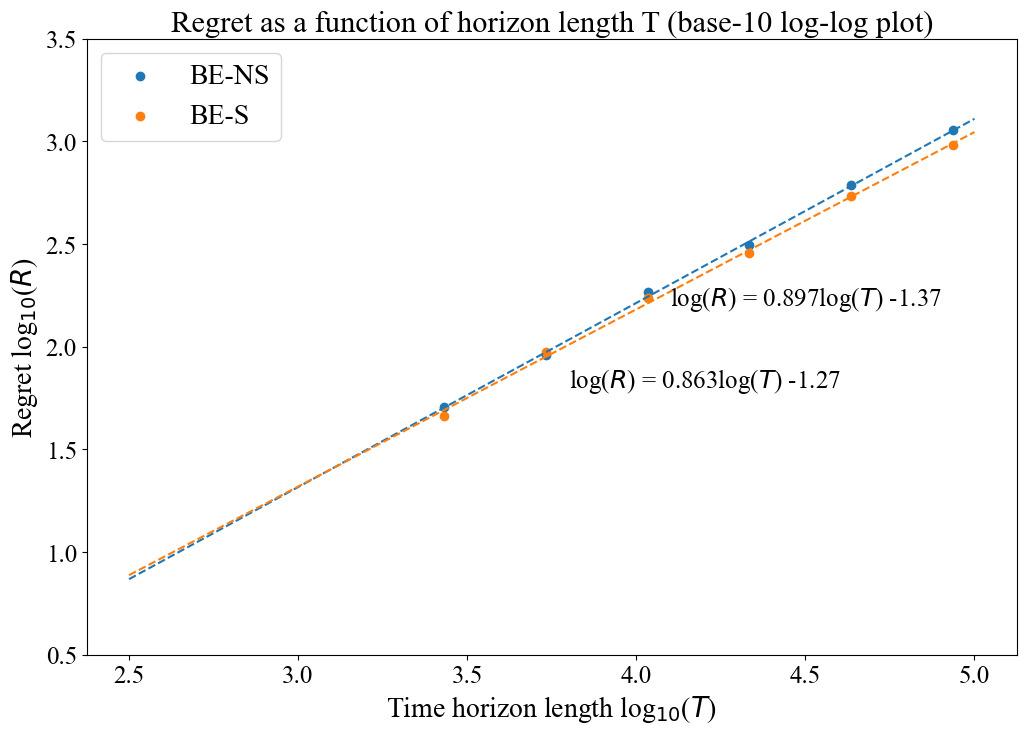

In [39]:
num_points = 6
x = np.log10(86404/2**np.arange(num_points-1,-1,-1))  # log(T)
# y = np.log10(np.mean(regrets,axis=0)[-num_points:])  # log(R) of Rexp3
y1 = np.log10(np.mean(regrets1,axis=0)[-num_points:])  # log(R) of BE-NS
y2 = np.log10(np.mean(regrets2,axis=0)[-num_points:])  # log(R) of BE-S

# Perform linear regression to find the best-fit line
# slope, intercept = np.polyfit(x, y, 1)
slope1, intercept1 = np.polyfit(x, y1, 1)
slope2, intercept2 = np.polyfit(x, y2, 1)

# Use Times New Roman font for LaTeX rendering
rc('font', family='Times New Roman')

# Plot the data points and the best-fit lines
plt.gcf().set_size_inches(12, 8)

# plt.scatter(x, y, label="Rexp3")
plt.scatter(x, y1, label="BE-NS")
plt.scatter(x, y2, label="BE-S")
plt.legend(fontsize=20)

x_extended = np.arange(2.5,5.5,0.5)
# line, = plt.plot(x_extended, slope * x_extended + intercept, '--', label="log($R$) = {:.3f}log($T$) {:.2f}".format(slope, intercept))
line1, = plt.plot(x_extended, slope1 * x_extended + intercept1, '--', label="log($R$) = {:.3f}log($T$) {:.2f}".format(slope1, intercept1))
line2, = plt.plot(x_extended, slope2 * x_extended + intercept2, '--', label="log($R$) = {:.3f}log($T$) {:.2f}".format(slope2, intercept2))

# Manually position the legend near the best fit lines
# plt.annotate(line.get_label(), xy=(3.4, 2.6), xytext=(3.4, 2.6), fontsize=18)
plt.annotate(line1.get_label(), xy=(4.1, 2.2), xytext=(4.1, 2.2), fontsize=18)
plt.annotate(line2.get_label(), xy=(3.8, 1.8), xytext=(3.8, 1.8), fontsize=18)


plt.xlabel('Time horizon length log$_{10}$($T$)', fontsize=20)
plt.ylabel('Regret log$_{10}$($R$)', fontsize=20)
plt.xticks(np.arange(2.5,5.5,0.5), fontsize=18)
plt.yticks(np.arange(0.5,4,0.5), fontsize=18)
plt.title("Regret as a function of horizon length T (base-10 log-log plot)", fontsize=22)